In [29]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [3]:
import os
import pandas as pd
import numpy as np
import talib as ta
from data_preparation import PreProcess, PivotLevels
from db_access import StockHistory, ExportToParquet, ExportToPickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

pd.options.display.max_columns = 200

## Preparacao dos datasets

O código abaixo utiliza os arquivos parquet previamente extraídos do banco de dados.

In [132]:
df_raw.shape, df_tech.shape

((2472, 19), (2383, 52))

In [135]:
pre_process = PreProcess()
parquet_exporter = ExportToParquet()
pickle_exporter = ExportToPickle()

raw_file_path = os.environ.get("RAW_DATA_PATH")
data_file_path = os.environ.get("DATASET_PATH")
model_base_path = os.environ.get("MODELS_PATH")
str_conn = os.environ.get("STR_CON")
stride_coef_ang = 1

# Colunas que serão usadas MinMaxScaler
columns_to_scale = ['close', 'open', 'low', 'high','rsi', 'macd', 'macdsignal', 'macdhist', 'slowk', 'slowd', 'willr', 'mfi',
                    'coef_ang_volume', 'var_volume', 'diff_volume_vol_med',
                    'diff_close_r1', 'diff_close_r2', 'diff_close_r3', 'diff_close_s1', 'diff_close_s2', 'diff_close_s3',
                    'diff_willr_20', 'diff_willr_80', 'dif_mfi_20', 'diff_mfi_80', 
                    'diff_rsi_70', 'diff_k_d']
# Colunas com sinal de negociação. O dataframe usado pelo modelo terá uma série temporal e colunas com sinal de negociação. A coluna com a série temporal
# será passada para autoencoder, que irá gerar um vetor que representa a série, este vetor será concatenado com as colunas de sinal e passarão por uma MLP
# que fará a classificação do ativo
signal_cols = ['DR3', 'M2', 'MA', 'MB', 'N/D', 'N1', 'N2', 'NM', 
               'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR', 'CDLTAKURI', 'CDLHANGINGMAN', 'CDLEVENINGDOJISTAR', 'CDL3OUTSIDE', 'CDLONNECK', 'CDLHAMMER', 'CDLHARAMICROSS',
               'diff_volume_vol_med', 'diff_close_r1', 'diff_close_r2', 'diff_close_r3', 'diff_close_s1',
               'diff_close_s2', 'diff_close_s3', 'coef_ang_volume', 'var_volume',
               'diff_willr_20', 'diff_willr_80', 'dif_mfi_20', 'diff_mfi_80', 'diff_rsi_70', 'diff_k_d',
               'volatiliade', 'coef_ang_close', 'coef_ang_volat', 'coef_ang_macdhist', 'coef_ang_rsi', 'coef_ang_mfi']
# Colunas que não precisam passar pelo MinMaxScaler
columns_to_pop = ['ticker', 'DR3', 'M2', 'MA', 'MB', 'N/D', 'N1', 'N2', 'NM', 
                  'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR', 'CDLTAKURI', 'CDLHANGINGMAN', 'CDLEVENINGDOJISTAR', 'CDL3OUTSIDE', 'CDLONNECK', 'CDLHAMMER', 'CDLHARAMICROSS',
                  'volatiliade', 'coef_ang_close', 'coef_ang_volat', 'coef_ang_macdhist', 'coef_ang_rsi', 'coef_ang_mfi']

path_content = os.listdir(raw_file_path)
# Filtra os arquivos parquet do diretório
path_content = [file for file in path_content if file.endswith(".parquet")]

# Faz o one hot encoder do mercado onde o emissor do ativo é negociado
dbo = StockHistory(str_conn)
markets = dbo.select_markets()
one_hot = OneHotEncoder(sparse=False)
one_hot.fit(markets.values)

for file in path_content:
    print(f"Processando arquivo: {raw_file_path}/{file}")
    df_raw = pd.read_parquet(os.path.join(raw_file_path, file))
    market_one_hot = pd.DataFrame(one_hot.transform(df_raw['market'].values.reshape(-1,1)), columns = one_hot.categories_[0])
    df_raw = pd.concat([df_raw.reset_index(), market_one_hot], axis=1).set_index('index')
    df_raw.set_index("dt_price", drop=False, inplace=True)

    # Calcula os indicadores técnicos definidos nas estratégias para cada ativo
    for strategy_name, strategy, df_tech in pre_process.calculate_strategy("strategies.json", df_raw):
        window_size = strategy["historic_period"]
        stride = strategy["stride"]
        profit_period = strategy["profit_period"]
        profit = strategy["profit"]

        # Ajusta d valor do ROC
        df_tech['roc'] = df_tech['roc']/100
        # Calcula a volatilidade do ativo no periodo window_size
        df_tech['volatiliade'] = df_tech['roc'].rolling(window=window_size).std()
        # Calcula a variacao do volume
        df_tech['var_volume'] = ta.ROC(df_tech['volume'], 1)/100
        df_tech[f'vol_med_{window_size}_days'] = df_tech['volume'].rolling(window=window_size).mean()
        df_tech['diff_volume_vol_med'] = df_tech['volume']/df_tech[f'vol_med_{window_size}_days']-1

        # Calcula os Pivot Levels
        pivot_levels = PivotLevels(high=df_tech['high'], low=df_tech['low'], close=df_tech['close'])

        # Diferenca entre os Pivot Levels e o preco de fechamento
        df_tech['diff_close_r1'] = df_tech['close'] - pivot_levels.R1
        df_tech['diff_close_r2'] = df_tech['close'] - pivot_levels.R2
        df_tech['diff_close_r3'] = df_tech['close'] - pivot_levels.R3
        df_tech['diff_close_s1'] = df_tech['close'] - pivot_levels.S1
        df_tech['diff_close_s2'] = df_tech['close'] - pivot_levels.S2
        df_tech['diff_close_s3'] = df_tech['close'] - pivot_levels.S3

        # Caclula o coeficiente angular da regressao do preco de fechamento e adiciona ao dataframe de treinamento
        df_tech['coef_ang_close'] = pre_process.linear_regression_slope(df_tech['close'], window_size=window_size, stride=stride_coef_ang)
        df_tech['coef_ang_volume'] = pre_process.linear_regression_slope(df_tech['volume'], window_size=window_size, stride=stride_coef_ang)
        # Remove os valores nulos do DataFrame
        df_tech.dropna(inplace=True)

        df_tech['coef_ang_volat'] = pre_process.linear_regression_slope(df_tech['volatiliade']*100, window_size=window_size, stride=stride_coef_ang)
        df_tech['coef_ang_macdhist'] = pre_process.linear_regression_slope(df_tech['macdhist'], window_size=window_size, stride=stride_coef_ang)
        df_tech['coef_ang_rsi'] = pre_process.linear_regression_slope(df_tech['rsi'], window_size=window_size, stride=stride_coef_ang)
        df_tech['coef_ang_mfi'] = pre_process.linear_regression_slope(df_tech['mfi'], window_size=window_size, stride=stride_coef_ang)

        # Remove os valores nulos do DataFrame
        df_tech.dropna(inplace=True)

        # Cria um dataframe auxilizar para armazenar as colunas que serao usadas no modelo, mas nao precisam ser redimensionadas 
        df_aux = pd.DataFrame()
        for col in columns_to_pop:
            df_aux[col] = df_tech.pop(col)

        scaler = MinMaxScaler().fit(df_tech[columns_to_scale])
        transformed_data = scaler.transform(df_tech[columns_to_scale])
        df_tech = pd.concat([df_aux.reset_index(), pd.DataFrame(transformed_data, columns=scaler.get_feature_names_out())], axis=1).set_index('dt_price', drop=False)

        # Formata o dataset para ser usado no modelo
        df_model = pre_process.format_dataset(df_raw, df_tech, window_size, stride, profit_period, profit, None, signal_cols)

        # Exporta o data set como um arquivo parquet
        parquet_exporter.export(df_model, os.path.join(data_file_path, strategy_name), file.split('.')[0])


Processando arquivo: data/raw/CPFE3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating WILLR_14...
Calculating MFI_14...
Calculating ROC...
Processando arquivo: data/raw/BEEF3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating WILLR_14...
Calculating MFI_14...
Calculating ROC...
Processando arquivo: data/raw/LOGG3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating WILLR_14...
Calculating MFI_14...
Calculating ROC...
Processando arquivo: data/raw/VIVT3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating WILLR_14...
Calculating MFI_14...
Calculating

In [136]:
pre_process = PreProcess()
random_seed = 42
test_size = 0.15
price_cols_to_delete = []

pre_process.create_train_test_dataset("strategies.json", test_size, random_seed, price_cols_to_delete)

Processando arquivo CPFE3.parquet na estrategia indicadores_com_sinais
Processando arquivo BEEF3.parquet na estrategia indicadores_com_sinais
Processando arquivo LOGG3.parquet na estrategia indicadores_com_sinais
Processando arquivo VIVT3.parquet na estrategia indicadores_com_sinais
Processando arquivo PLPL3.parquet na estrategia indicadores_com_sinais
Processando arquivo KEPL3.parquet na estrategia indicadores_com_sinais
Processando arquivo ROMI3.parquet na estrategia indicadores_com_sinais
Processando arquivo HAPV3.parquet na estrategia indicadores_com_sinais
Processando arquivo ARZZ3.parquet na estrategia indicadores_com_sinais
Processando arquivo BBSE3.parquet na estrategia indicadores_com_sinais
Processando arquivo SOMA3.parquet na estrategia indicadores_com_sinais
Processando arquivo PETR3.parquet na estrategia indicadores_com_sinais
Processando arquivo TRPL4.parquet na estrategia indicadores_com_sinais
Processando arquivo AGRO3.parquet na estrategia indicadores_com_sinais
Proces

## Definição da arquitetura do modelo
O modelo será composto por duas redes neurais:<br>
1. Uma LSTM, que tem como objetivo processar a série temporal do preço do ativo e seus respectivos indicadores técnicos
2. Uma MLP que receberá a saída da LSTM e os demais sinais de negociação calculados na etapa de preparação das features.<br>
<p>A saída das duas redes será concatenada e este conjunto de features será processado por camadas dense até gerar a saída do modelo que será 1 se a ação for classificada como "ação que irá se valorizar mais de X% em Y dias" ou 0 caso contrário.</p>

Model: "model_55"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_218_input (InputLayer)   [(None, 38)]         0           []                               
                                                                                                  
 dense_218 (Dense)              (None, 38)           1482        ['dense_218_input[0][0]']        
                                                                                                  
 dropout_146 (Dropout)          (None, 38)           0           ['dense_218[0][0]']              
                                                                                                  
 input_20 (InputLayer)          [(None, 45, 12)]     0           []                               
                                                                                           

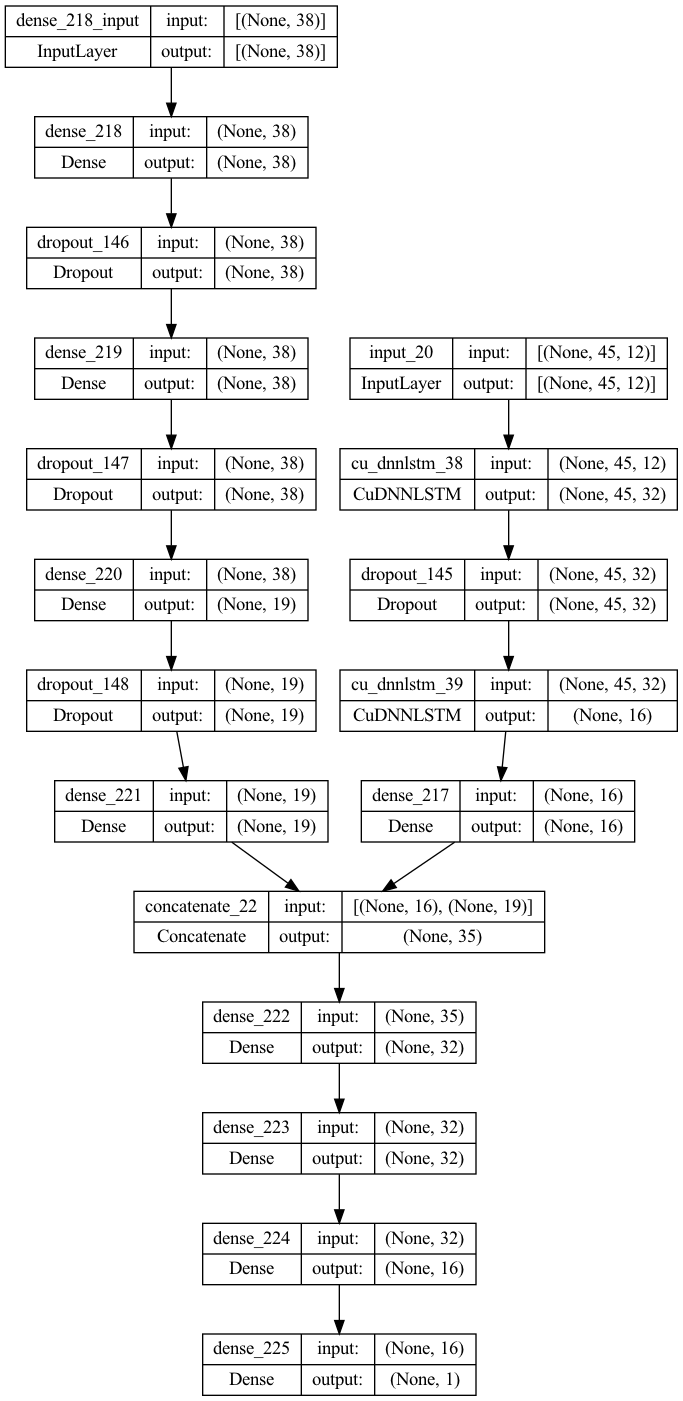

In [138]:
from keras.layers import CuDNNLSTM, Input, RepeatVector, TimeDistributed, Dense, concatenate, Dropout
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.optimizers import Adam


preprocess = PreProcess()
metric = "AUC"

# Define os callback que serão usados no treinamento do modelo
cb_early_stopping = EarlyStopping(monitor=f'val_{metric.lower()}', 
                               patience=20, 
                               min_delta=0.0005, 
                               mode='max')

cb_model_checkpoint = ModelCheckpoint("data/tf_models/final_model/model-test-{epoch:02d}-{val_auc:.4f}.h5",
                                      monitor=f'val_{metric.lower()}',
                                      save_best_only=True,
                                      verbose=1,
                                      mode="max")

cb_reduce_lr_on_plateu = ReduceLROnPlateau(monitor=f"val_{metric.lower()}",
                                            factor=0.1,
                                            patience=10,
                                            verbose=0,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=0,
                                            min_lr=0.0000001)
                                            
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/train_data.parquet")
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

X_TS_Train = np.array([val[0] for val in df_train.values])
X_TS_Test = np.array([val[0] for val in df_test.values])

Y_train = df_train.pop('label')
Y_test = df_test.pop('label')

X_SIG_Train = df_train[df_train.columns[~df_train.columns.isin(['series'])]].values
X_SIG_Test = df_test[df_test.columns[~df_test.columns.isin(['series'])]].values

# Rede LSTM
input_ts_data = Input((X_TS_Train.shape[1], X_TS_Train.shape[2]) )
lstm_layer = CuDNNLSTM(32, input_shape=X_TS_Train.shape, return_sequences=True)(input_ts_data)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_layer = CuDNNLSTM(16, input_shape=X_TS_Train.shape)(lstm_layer)
lstm_layer = Dense(16, activation="relu")(lstm_layer)
model_lstm = Model(input_ts_data, lstm_layer)

# Rede MLP para tratar os sinais de negociação
mlp = Sequential()
mlp.add(Dense(X_SIG_Train.shape[1], input_dim = X_SIG_Train.shape[1], activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1], activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1]//2, activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1]//2, activation="relu"))

# Concatena os modelos
final_layers = concatenate([model_lstm.output, mlp.output])
final_layers = Dense(32, activation="relu")(final_layers)
final_layers = Dense(32, activation="relu")(final_layers)
final_layers = Dense(16, activation="relu")(final_layers)
final_layers = Dense(1, activation='sigmoid')(final_layers)

optimizer = Adam(learning_rate=0.002)
full_model = Model(inputs=[model_lstm.input, mlp.input], outputs=final_layers)

full_model.compile(loss='binary_crossentropy', 
                   optimizer=optimizer,
                   metrics=[metric])
full_model.summary()
plot_model(full_model, 'images/full_model.png', show_shapes=True)


In [139]:
batch_size = 64
epochs = 200

full_model.fit(
	x=[X_TS_Train, X_SIG_Train], y=Y_train,
	validation_data=([X_TS_Test, X_SIG_Test], Y_test),
    callbacks=[cb_early_stopping, cb_model_checkpoint], #, cb_reduce_lr_on_plateu
	epochs=epochs, batch_size=batch_size)


Epoch 1/200


2023-01-30 20:47:34.907111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


857/857 [==============================] - ETA: 0s - loss: 0.6688 - auc: 0.5280

2023-01-30 20:49:36.826038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_auc improved from -inf to 0.50875, saving model to data/tf_models/final_model/model-test-01-0.5088.h5
857/857 [==============================] - 138s 149ms/step - loss: 0.6688 - auc: 0.5280 - val_loss: 0.6697 - val_auc: 0.5088
Epoch 2/200
857/857 [==============================] - ETA: 0s - loss: 0.6672 - auc: 0.5401
Epoch 2: val_auc improved from 0.50875 to 0.50879, saving model to data/tf_models/final_model/model-test-02-0.5088.h5
857/857 [==============================] - 115s 134ms/step - loss: 0.6672 - auc: 0.5401 - val_loss: 0.6731 - val_auc: 0.5088
Epoch 3/200
857/857 [==============================] - ETA: 0s - loss: 0.6670 - auc: 0.5398
Epoch 3: val_auc improved from 0.50879 to 0.51278, saving model to data/tf_models/final_model/model-test-03-0.5128.h5
857/857 [==============================] - 115s 134ms/step - loss: 0.6670 - auc: 0.5398 - val_loss: 0.6703 - val_auc: 0.5128
Epoch 4/200
857/857 [==============================] - ETA: 0s - loss: 0.6667 - auc: 0.54

In [5]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model

model = load_model("data/tf_models/final_model/model-test-136-0.5740.h5") # model-53-0.5709.h5

preprocess = PreProcess()
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

X_TS_Test = np.array([val[0] for val in df_test.values])
Y_test = df_test.pop('label')
X_SIG_Test = df_test[df_test.columns[~df_test.columns.isin(['series'])]].values

Y_test_predict = (model.predict([X_TS_Test, X_SIG_Test]).flatten() > 0.5).astype(int)
print(f"Accuracy: {accuracy_score(Y_test.values, Y_test_predict):.4f}")
print("Matriz de confusao:\n", confusion_matrix(Y_test.values, Y_test_predict))
print(f"Precision: {precision_score(Y_test.values, Y_test_predict):.4f}")
print(f"Recall: {recall_score(Y_test.values, Y_test_predict):.4f}")
print(f"F1 Score: {f1_score(Y_test.values, Y_test_predict):.4f}")

2023-01-31 07:14:13.959303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 15s 47ms/step
Accuracy: 0.6103
Matriz de confusao:
 [[5226  700]
 [3106  734]]
Precision: 0.5119
Recall: 0.1911
F1 Score: 0.2783


In [ ]:
# model-53-0.5709.h5
# Accuracy: 0.6111
# Matriz de confusao:
#  [[5427  499]
#  [3299  541]]
# Precision: 0.5202
# Recall: 0.1409
# F1 Score: 0.2217

# model-test-146-0.5771.h5
# Accuracy: 0.6155
# Matriz de confusao:
#  [[5384  542]
#  [3213  627]]
# Precision: 0.5364
# Recall: 0.1633
# F1 Score: 0.2503